In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

import ee

try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()

In [45]:
pts18 = gpd.read_file(r'C:\Users\coach\myfiles\postdoc\Invasives\aliens_sep2018_bioscape2023.shp')

pts18.loc[pts18['change'] == 0, '2023_class'] = pts18['class']
pts23 = pts18.dropna(subset=['2023_class'])
pts23 = pts23.loc[pts23['2023_class'] != 12]

In [46]:
# https://code.earthengine.google.com/2ecd5164c633d93fa03a72834727cb5f-view protected areas

pas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq('NAME','Cape Floral Region Protected Areas'))

# convert to geopandas dataframe
gdfpas = ee.data.computeFeatures({
    'expression': pas,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

gdfpas.crs = 'EPSG:4326'

In [7]:
!jupyter trust Figure 1.ipynb

gdfpas.explore()

[TrustNotebookApp] ERROR | Notebook missing: Figure
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\folium\features.py:1204: UserWarning: GeoJsonTooltip is not configured to render for GeoJson GeometryCollection geometries. Please consider reworking these features: [{'CONS_OBJ': 'Not Applicable', 'DESIG': 'World Heritage Site (natural or mixed)', 'DESIG_ENG': 'World Heritage Site (natural or mixed)', 'DESIG_TYPE': 'International', 'GIS_AREA': 11017.2777374462, 'GIS_M_AREA': 27.1924069187658, 'GOV_TYPE': 'Federal or national ministry or agency', 'INT_CRIT': '(ix)(x)', 'ISO3': 'ZAF', 'IUCN_CAT': 'Not Applicable', 'MANG_AUTH': 'Cape Nature', 'MANG_PLAN': 'Not Reported', 'MARINE': '0', 'METADATAID': 946, 'NAME': 'Cape Floral Region Protected Areas', 'NO_TAKE': 'Not Applicable', 'NO_TK_AREA': 0, 'ORIG_NAME': 'Aires protégées de la Région florale du Cap', 'OWN_TYPE': 'State', 'PARENT_ISO': 'ZAF', 'PA_DEF': '1', 'REP_AREA': 10947.42, 'REP_M_AREA': 0, 'STATUS': 'Inscribed', 'STATUS_YR': 

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

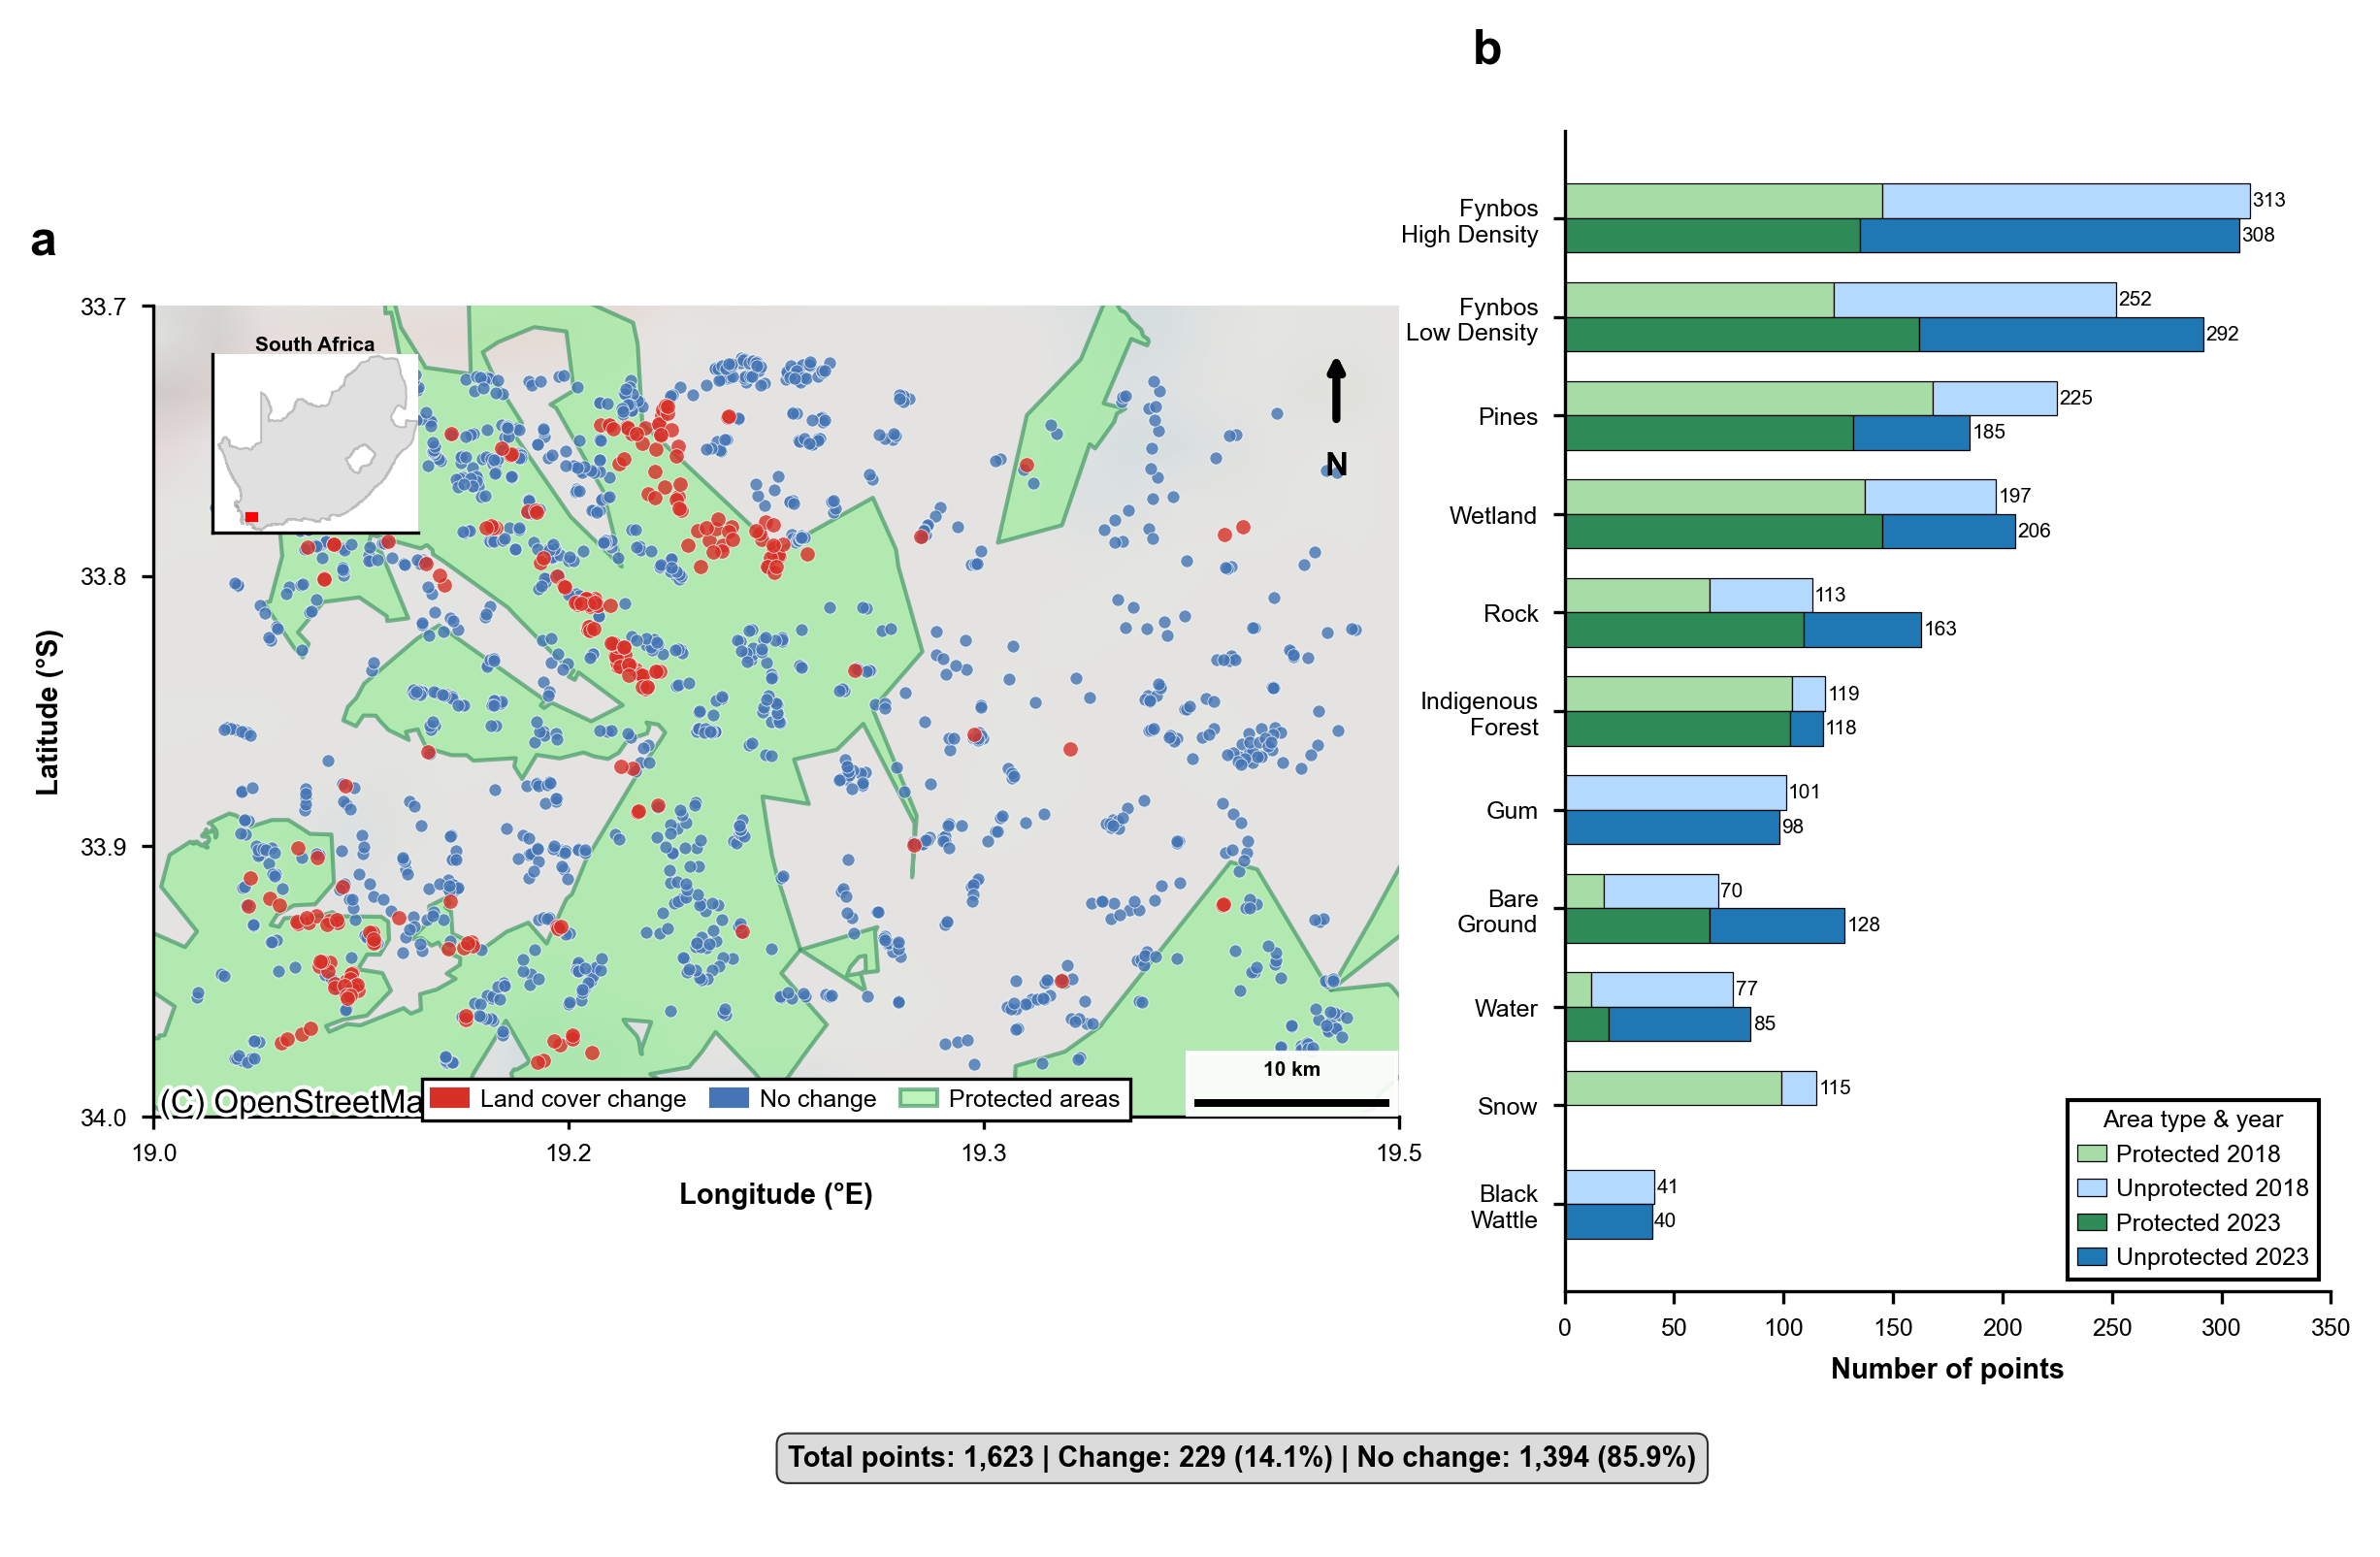

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
from matplotlib.transforms import Bbox
from matplotlib.gridspec import GridSpec

# =============================================================================
# CONFIGURATION
# =============================================================================

# Data sources
POINTS_GDF = pts if 'pts' in globals() else None
PROTECTED_AREAS_GDF = gdfpas if 'gdfpas' in globals() else None
SA_BOUNDARY_PATH = r"C:\Users\coach\myfiles\data\zaf_adm_sadb_ocha_20201109_SHP\zaf_admbnda_adm0_sadb_ocha_20201109.shp"

# Column configurations
CHANGE_COLUMN = "change"
CLASS_2018_COLUMN = "class"
CLASS_2023_COLUMN = "2023_class"

# Class mapping
classDict = {
    "0": "Bare Ground", "1": "Black Wattle", "2": "Pines", 
    "3": "Fynbos High Density", "4": "Fynbos Low Density", "5": "Gum", 
    "6": "Indigenous Forest", "7": "Rock", "8": "Wetland",
    "9": "Snow", "10": "Water"
}

# Styling
CHANGE_COLORS = {'Change': '#D73027', 'No change': '#4575B4'}
BAR_COLORS = ['#4472C4', '#70AD47']
POINT_SIZES = {'No change': 10, 'Change': 14}

def create_sample_data():
    """Generate sample data if real data not available"""
    np.random.seed(42)
    n = 200
    
    # Focus on Cape Town area
    lon = np.random.uniform(18.3, 18.9, n)
    lat = np.random.uniform(-34.4, -33.8, n)
    
    points = gpd.GeoDataFrame({
        CHANGE_COLUMN: np.random.choice([0, 1], n, p=[0.75, 0.25]),
        CLASS_2018_COLUMN: np.random.choice(list(classDict.keys()), n),
        CLASS_2023_COLUMN: np.random.choice(list(classDict.keys()), n),
        'geometry': gpd.points_from_xy(lon, lat)
    }, crs='EPSG:4326')
    
    # Map to descriptive names
    points[CLASS_2018_COLUMN] = points[CLASS_2018_COLUMN].map(classDict)
    points[CLASS_2023_COLUMN] = points[CLASS_2023_COLUMN].map(classDict)
    points['change_label'] = points[CHANGE_COLUMN].map({0: 'No change', 1: 'Change'})
    
    # Sample protected area
    from shapely.geometry import Polygon
    protected = gpd.GeoDataFrame(
        {'id': [1]}, 
        geometry=[Polygon([(18.35, -34.1), (18.55, -34.0), (18.6, -34.3), (18.4, -34.25)])], 
        crs='EPSG:4326')
    
    return points, protected

def create_publication_figure():
    """Create Nature-style publication figure with improved layout"""
    
    # Set Nature-style publication styling
    plt.rcParams.update({
        'font.family': ['Arial', 'Helvetica', 'sans-serif'],
        'font.size': 7,
        'axes.linewidth': 0.8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 2,
        'ytick.minor.size': 2,
        'xtick.labelsize': 6,
        'ytick.labelsize': 6,
        'legend.frameon': True,
        'legend.framealpha': 1.0,
        'legend.edgecolor': 'black',
        'legend.fancybox': False,
        'legend.fontsize': 6
    })
    
    # Load data
    if POINTS_GDF is not None and PROTECTED_AREAS_GDF is not None:
        points = POINTS_GDF.copy()
        protected = PROTECTED_AREAS_GDF.copy()
        points['change_label'] = points[CHANGE_COLUMN].map({0: 'No change', 1: 'Change'})
    else:
        points, protected = create_sample_data()
    
    # Load South Africa boundary
    try:
        sa_boundary = gpd.read_file(SA_BOUNDARY_PATH).to_crs(points.crs)
    except:
        # Create a simple boundary if file not found
        from shapely.geometry import Polygon
        sa_boundary = gpd.GeoDataFrame(
            {'name': ['South Africa']},
            geometry=[Polygon([
                [16.45, -34.82], [32.83, -34.82], [32.83, -22.22], [16.45, -22.22]
            ])],
            crs='EPSG:4326'
        )
    
    # Calculate extents
    bounds = points.total_bounds
    buffer = 0.02
    extent = [bounds[0]-buffer, bounds[2]+buffer, bounds[1]-buffer, bounds[3]+buffer]
    
    # Prepare stacked bar chart data - Protected Areas vs Total
    # Identify points within protected areas using spatial join
    if len(protected) > 0:
        points_in_protected = gpd.sjoin(points, protected, how='inner', predicate='within')
        protected_2018_counts = points_in_protected[CLASS_2018_COLUMN].value_counts()
        protected_2023_counts = points_in_protected[CLASS_2023_COLUMN].value_counts()
    else:
        protected_2018_counts = pd.Series(dtype=int)
        protected_2023_counts = pd.Series(dtype=int)
    
    # Get total counts
    total_2018_counts = points[CLASS_2018_COLUMN].value_counts()
    total_2023_counts = points[CLASS_2023_COLUMN].value_counts()
    
    # Get top classes based on total occurrence
    all_classes = sorted(set(total_2018_counts.index) | set(total_2023_counts.index), 
                        key=lambda x: total_2018_counts.get(x, 0) + total_2023_counts.get(x, 0), 
                        reverse=True)
    
    # Map class names
    display_classes = []
    for cls in all_classes:
        if str(cls) in classDict:
            display_classes.append(classDict[str(cls)])
        elif cls in classDict.values():
            display_classes.append(cls)
        else:
            display_classes.append(str(cls))
    
    # Create dataframe for stacked bars
    df_counts = pd.DataFrame({
        'Protected_2018': [protected_2018_counts.get(cls, 0) for cls in all_classes],
        'Unprotected_2018': [total_2018_counts.get(cls, 0) - protected_2018_counts.get(cls, 0) for cls in all_classes],
        'Protected_2023': [protected_2023_counts.get(cls, 0) for cls in all_classes],
        'Unprotected_2023': [total_2023_counts.get(cls, 0) - protected_2023_counts.get(cls, 0) for cls in all_classes]
    }, index=display_classes)
    
    # Create figure with Nature-style dimensions (smaller, more compact)
    fig = plt.figure(figsize=(8.5, 6), dpi=300)
    
    # Create compact gridspec with better spacing for panel B
    gs = GridSpec(2, 3, height_ratios=[1, 0.12], width_ratios=[1.3, 0.1, 0.8],
                  hspace=0.15, wspace=0.05, 
                  left=0.08, right=0.96, top=0.92, bottom=0.12)
    
    # Create axes
    ax_map = fig.add_subplot(gs[0, 0])      # Map panel
    ax_bar = fig.add_subplot(gs[0, 2])      # Bar chart panel
    ax_stats = fig.add_subplot(gs[1, :])    # Statistics below everything
    
    # Hide axes for stats
    ax_stats.axis('off')
    
    # Create inset map (top-left corner of main map)
    inset_pos = [0.02, 0.72, 0.22, 0.22]  # Smaller inset
    ax_inset = ax_map.inset_axes(inset_pos)
    
    # === INSET MAP ===
    sa_boundary.plot(ax=ax_inset, color='lightgray', edgecolor='darkgray', alpha=0.7, linewidth=0.5)
    
    # Add study area rectangle
    from matplotlib.patches import Rectangle
    rect = Rectangle((extent[0], extent[2]), extent[1]-extent[0], extent[3]-extent[2],
                    fill=False, edgecolor='red', linewidth=1.5, zorder=10)
    ax_inset.add_patch(rect)
    
    ax_inset.set_xlim(16, 33)
    ax_inset.set_ylim(-35, -22)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_title('South Africa', fontsize=5, fontweight='bold', pad=1)
    
    # Clean inset border
    for spine in ax_inset.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('black')
    
    # === PANEL A: MAP ===
    # Plot South Africa boundary
    sa_boundary.plot(ax=ax_map, color='lightgray', edgecolor='darkgray', alpha=0.5, linewidth=0.5)
    
    # Plot protected areas
    if len(protected) > 0:
        protected.plot(ax=ax_map, facecolor='lightgreen', edgecolor='#2E8B57', 
                    linewidth=1, alpha=0.6, zorder=2)
    
    # Plot points with refined styling
    for category in ['No change', 'Change']:
        mask = points['change_label'] == category
        if mask.any():
            points[mask].plot(ax=ax_map, color=CHANGE_COLORS[category], 
                            markersize=POINT_SIZES[category], alpha=0.8,
                            edgecolor='white', linewidth=0.2, zorder=3)
    
    # Add basemap
    try:
        ctx.add_basemap(ax=ax_map, crs=points.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6)
    except:
        pass
    
    # Map formatting
    ax_map.set_xlim(extent[0], extent[1])
    ax_map.set_ylim(extent[2], extent[3])
    ax_map.set_xlabel('Longitude (°E)', fontweight='bold', fontsize=7)
    ax_map.set_ylabel('Latitude (°S)', fontweight='bold', fontsize=7)
    
    # Clean tick formatting
    x_ticks = np.linspace(extent[0], extent[1], 4)
    y_ticks = np.linspace(extent[2], extent[3], 4)
    ax_map.set_xticks(x_ticks)
    ax_map.set_yticks(y_ticks)
    ax_map.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])
    ax_map.set_yticklabels([f'{abs(tick):.1f}' for tick in y_ticks])
    
    # Scale bar - positioned lower right to avoid north arrow
    scalebar = ScaleBar(111319.9, units="m", location='lower right',
                    scale_loc="top", font_properties={'size': 5, 'weight': 'bold'},
                    box_color='white', box_alpha=0.9, pad=0.3)
    ax_map.add_artist(scalebar)
    
    # North arrow - positioned in TOP RIGHT as requested
    ax_map.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.85),
                    xycoords='axes fraction', ha='center', va='center',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    ax_map.text(0.95, 0.82, 'N', transform=ax_map.transAxes, 
                fontsize=8, fontweight='bold', ha='center', va='top')
    
    # Panel label
    ax_map.text(-0.1, 1.05, 'a', transform=ax_map.transAxes, 
                fontsize=12, fontweight='bold', va='bottom')
    
    # === LEGEND IN PANEL A (CENTER BOTTOM) ===
    legend_elements = [
        mpatches.Patch(color=CHANGE_COLORS['Change'], label='Land cover change'),
        mpatches.Patch(color=CHANGE_COLORS['No change'], label='No change')
    ]
    if len(protected) > 0:
        legend_elements.append(
            mpatches.Patch(facecolor='lightgreen', edgecolor='#2E8B57', 
                        linewidth=1, alpha=0.6, label='Protected areas'))
    
    # Place legend at bottom center of map panel
    legend = ax_map.legend(handles=legend_elements, loc='lower center', ncol=3, 
                          fontsize=6, framealpha=1.0, columnspacing=1.0,
                          handlelength=1.5, handletextpad=0.5,
                          bbox_to_anchor=(0.5, -0.02))
    legend.get_frame().set_linewidth(0.8)
    
    # === PANEL B: STACKED BAR CHART ===
    y_pos = np.arange(len(all_classes))
    width = 0.35

    # Define color palettes (lighter = 2018, darker = 2023)
    protected_colors = ['#A6DDA6', '#2E8B57']  # light green, dark green
    unprotected_colors = ['#B3D9FF', '#1F78B4']  # light blue, dark blue

    # 2018 stacked bars
    ax_bar.barh(y_pos - width/2, df_counts['Protected_2018'], width,
                color=protected_colors[0], edgecolor='black', linewidth=0.3,
                label='Protected 2018')
    ax_bar.barh(y_pos - width/2, df_counts['Unprotected_2018'], width,
                left=df_counts['Protected_2018'], color=unprotected_colors[0],
                edgecolor='black', linewidth=0.3, label='Unprotected 2018')

    # 2023 stacked bars
    ax_bar.barh(y_pos + width/2, df_counts['Protected_2023'], width,
                color=protected_colors[1], edgecolor='black', linewidth=0.3,
                label='Protected 2023')
    ax_bar.barh(y_pos + width/2, df_counts['Unprotected_2023'], width,
                left=df_counts['Protected_2023'], color=unprotected_colors[1],
                edgecolor='black', linewidth=0.3, label='Unprotected 2023')

    # Add value labels
    for i, (p18, u18, p23, u23) in enumerate(zip(df_counts['Protected_2018'],
                                                 df_counts['Unprotected_2018'],
                                                 df_counts['Protected_2023'],
                                                 df_counts['Unprotected_2023'])):
        total_2018 = p18 + u18
        total_2023 = p23 + u23
        if total_2018 > 0:
            ax_bar.text(total_2018 + 1, y_pos[i] - width/2, f'{total_2018}',
                        va='center', ha='left', fontsize=5)
        if total_2023 > 0:
            ax_bar.text(total_2023 + 1, y_pos[i] + width/2, f'{total_2023}',
                        va='center', ha='left', fontsize=5)

    # Prepare compact class labels
    class_labels = []
    for cls in df_counts.index:
        cls_str = str(cls)
        if len(cls_str) > 10:
            if ' ' in cls_str:
                words = cls_str.split()
                if len(words) == 2:
                    class_labels.append(f'{words[0]}\n{words[1]}')
                else:
                    mid = len(words) // 2
                    class_labels.append('\n'.join([' '.join(words[:mid]), ' '.join(words[mid:])]))
            else:
                class_labels.append(cls_str)
        else:
            class_labels.append(cls_str)

    # Axes formatting
    ax_bar.set_xlabel('Number of points', fontweight='bold', fontsize=7)
    # ax_bar.set_ylabel('Land cover class', fontweight='bold', fontsize=7)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_labels, fontsize=6)
    ax_bar.invert_yaxis()
    ax_bar.set_xlim(0, 350)

    # Legend
    ax_bar.legend(ncol=1, fontsize=6, frameon=True, loc='lower right',
                  title="Area type & year", title_fontsize=6,
                  columnspacing=0.8, handlelength=1.2, handletextpad=0.4)

    # Panel label
    ax_bar.text(-0.12, 1.05, 'b', transform=ax_bar.transAxes,
                fontsize=12, fontweight='bold', va='bottom')


    
    # === SUMMARY STATISTICS (COMPACT) ===
    total_points = len(points)
    change_points = len(points[points['change_label'] == 'Change'])
    no_change_points = len(points[points['change_label'] == 'No change'])
    change_percent = (change_points / total_points) * 100
    
    summary_text = f"Total points: {total_points:,} | " \
                  f"Change: {change_points:,} ({change_percent:.1f}%) | " \
                  f"No change: {no_change_points:,} ({100-change_percent:.1f}%)"
    
    ax_stats.text(0.5, 0.5, summary_text, transform=ax_stats.transAxes,
                 ha='center', va='center', fontsize=7, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", 
                          alpha=0.8, edgecolor='black', linewidth=0.5))
    
    return fig

def main(points_gdf=None, protected_areas_gdf=None):
    """Main function"""
    global POINTS_GDF, PROTECTED_AREAS_GDF
    if points_gdf is not None:
        POINTS_GDF = points_gdf
    if protected_areas_gdf is not None:
        PROTECTED_AREAS_GDF = protected_areas_gdf
    
    fig = create_publication_figure()
    plt.show()
    return fig

if __name__ == "__main__":
    main()